# 1. Define a simple Deep Model

In [ ]:

model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(784,)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 2. Define Callbacks



# 2. Use Keras Callbacks. These are utilities that run at specific stages of training (e.g., at the end of every epoch) to adjust the learning rate or stop training altogether.

**Step Decay**

In [ ]:
import math
from tensorflow.keras import callbacks

# Define the step decay logic
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 10.0
    # Equation: lrate = initial * (drop ^ floor(epoch / epochs_drop))
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

# Initialize the scheduler callback
lr_scheduler = callbacks.LearningRateScheduler(step_decay, verbose=1)

# Usage in model.fit
history = model.fit(
    x_train, y_train,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[lr_scheduler]
)

**Exponential Decay**

In [ ]:
from tensorflow.keras import optimizers

# Define the schedule
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000, # Number of steps before decreasing
    decay_rate=0.96,   # The base of the exponential
    staircase=False    # Set to True for a step-like effect
)

# Pass the schedule directly to the optimizer
optimizer = optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')

**ReduceLRonPlateau**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks


# Learning Rate Decay: Reduces LR by factor of 0.2 if val_loss plateaus for 3 epochs
lr_decay = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

# 3. Train the Model
# Pass the callbacks list to the fit function
history = model.fit(
    x_train, y_train,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[early_stop, lr_decay]
)

**Early Stopping**

In [ ]:
# Early Stopping: Stops training if validation loss doesn't improve for 5 epochs
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

#Comparative Analysis of Different LR Scheduling Techniques

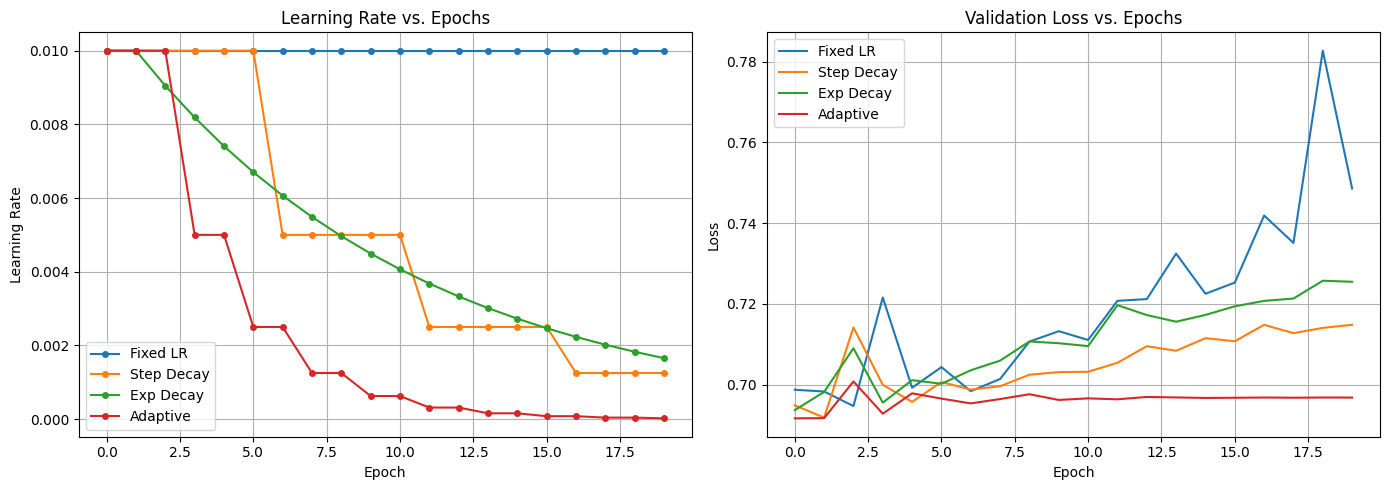

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
import matplotlib.pyplot as plt

# 1. Setup Synthetic Data (to ensure the code runs without external datasets)
x_train = np.random.random((1000, 20))
y_train = np.random.randint(0, 2, (1000,))
x_val = np.random.random((200, 20))
y_val = np.random.randint(0, 2, (200,))

# 2. Scheduling Functions
def step_decay(epoch):
    initial_lr = 0.01
    drop = 0.5
    epochs_drop = 5
    return float(initial_lr * (drop ** (epoch // epochs_drop)))

def exp_decay(epoch):
    initial_lr = 0.01
    k = 0.1
    return float(initial_lr * np.exp(-k * epoch))

# 3. Training Function
def train_model(name, callback_list=None, initial_lr=0.01):
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(20,)),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=initial_lr),
                  loss='binary_crossentropy')

    # Custom callback to capture LR at each epoch
    class LRHistory(callbacks.Callback):
        def on_epoch_begin(self, epoch, logs=None):
            if not hasattr(self, 'lrs'): self.lrs = []
            self.lrs.append(float(tf.keras.backend.get_value(self.model.optimizer.learning_rate)))

    lr_tracker = LRHistory()
    cbs = [lr_tracker] + (callback_list if callback_list else [])

    history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val),
                        callbacks=cbs, verbose=0)
    return history.history['val_loss'], lr_tracker.lrs

# 4. Run Comparisons
results = {
    'Fixed LR': train_model('Fixed'),
    'Step Decay': train_model('Step', [callbacks.LearningRateScheduler(step_decay)]),
    'Exp Decay': train_model('Exp', [callbacks.LearningRateScheduler(exp_decay)]),
    'Adaptive': train_model('Adaptive', [callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)])
}

# 5. Visualization
plt.figure(figsize=(14, 5))

# Plot 1: Learning Rate Behavior
plt.subplot(1, 2, 1)
for name, (loss, lrs) in results.items():
    plt.plot(lrs, label=name, marker='o', markersize=4)
plt.title('Learning Rate vs. Epochs')
plt.xlabel('Epoch'); plt.ylabel('Learning Rate'); plt.legend(); plt.grid(True)

# Plot 2: Convergence (Validation Loss)
plt.subplot(1, 2, 2)
for name, (loss, lrs) in results.items():
    plt.plot(loss, label=name)
plt.title('Validation Loss vs. Epochs')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()